# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Transfer Learning Practice")
mlflow.set_tag("mlflow.runName", "inital run")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from classification_mapping import CLASSIFICATION_MAPPING
from torchmetrics import Accuracy, Precision, Recall, F1Score

DATA_DIR = 'data'
TRANSLATED_DATA_DIR = 'data_translated'

In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)

        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [7]:
print(len(data))

175


In [8]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [9]:
dataset = SignDataset(data, labels)
len(dataset)

175

In [10]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

140
35


In [11]:
train_dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 14, shuffle = True)

In [12]:
for data, label in train_dataloader:
    break

In [13]:
print(data.shape)

torch.Size([32, 3, 224, 224])


In [14]:
print(label.shape)

torch.Size([32])


# Loading Pre-trained Model from Pytorch

In [15]:
model = models.resnet50(weights = models.ResNet50_Weights)
num_classes = 4 # Change output to 4 for desired classification task
model.fc = nn.Linear(model.fc.in_features, num_classes)

C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
for param in model.parameters():
 param.requires_grad = False
# Unfreeze the last layer
for param in model.fc.parameters():
 param.requires_grad = True

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model training

In [18]:
num_epochs = 400
train_losses, val_losses = [], []

model.to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    for image, labels in tqdm(train_dataloader, desc = "Training loop"):
        image, labels = image.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for image, labels in tqdm(test_dataloader, desc = "Validation loop"):
            image, labels = image.to(DEVICE), labels.to(DEVICE)
            outputs = model(image)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s" % (epoch + 1, num_epochs, train_loss, val_loss))

Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 400 - Train loss: 1.4728153467178344 , Validation loss: 1.2729896068573


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 400 - Train loss: 1.2014590794699533 , Validation loss: 1.0659554719924926


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 400 - Train loss: 0.9579010728427342 , Validation loss: 0.8836582779884339


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 400 - Train loss: 0.8448394795826503 , Validation loss: 0.747191870212555


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 400 - Train loss: 0.7300818637439183 , Validation loss: 0.6329918026924133


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 400 - Train loss: 0.6475752578462873 , Validation loss: 0.5853413224220276


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 400 - Train loss: 0.5539405989646912 , Validation loss: 0.5521048903465271


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 400 - Train loss: 0.5494123182977949 , Validation loss: 0.47275131940841675


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 400 - Train loss: 0.4896457634653364 , Validation loss: 0.47448272705078126


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 400 - Train loss: 0.4344916067804609 , Validation loss: 0.42478779554367063


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 400 - Train loss: 0.36889705317361016 , Validation loss: 0.3558416604995728


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 400 - Train loss: 0.3567964506149292 , Validation loss: 0.33828173875808715


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 400 - Train loss: 0.3090949962820326 , Validation loss: 0.33537558913230897


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 400 - Train loss: 0.3628455409833363 , Validation loss: 0.294333016872406


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 400 - Train loss: 0.28612528579575675 , Validation loss: 0.2849258899688721


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 400 - Train loss: 0.29584749851908004 , Validation loss: 0.26067701876163485


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 400 - Train loss: 0.24739138347761971 , Validation loss: 0.2391473263502121


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 400 - Train loss: 0.2919799295493535 , Validation loss: 0.24232030510902405


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 400 - Train loss: 0.23695452920028143 , Validation loss: 0.26098679602146146


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 400 - Train loss: 0.23087081125804357 , Validation loss: 0.20305318236351014


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 400 - Train loss: 0.22013385925974166 , Validation loss: 0.2038593351840973


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 400 - Train loss: 0.19774269359452384 , Validation loss: 0.19887767136096954


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 400 - Train loss: 0.20429251666579928 , Validation loss: 0.201084603369236


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 400 - Train loss: 0.19514019318989345 , Validation loss: 0.17629297077655792


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 400 - Train loss: 0.22128733192171368 , Validation loss: 0.16696085035800934


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 400 - Train loss: 0.17600491694041662 , Validation loss: 0.18106120228767394


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 400 - Train loss: 0.2146138506276267 , Validation loss: 0.1599650949239731


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 400 - Train loss: 0.15746234961918423 , Validation loss: 0.15791517198085786


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 400 - Train loss: 0.1673241032872881 , Validation loss: 0.14863060265779496


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 400 - Train loss: 0.14685569043670382 , Validation loss: 0.15430841147899627


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 400 - Train loss: 0.18920200075422014 , Validation loss: 0.12947309613227845


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 400 - Train loss: 0.14231678639139447 , Validation loss: 0.12452379763126373


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 400 - Train loss: 0.15456438226359231 , Validation loss: 0.12126746028661728


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 400 - Train loss: 0.12352040656975337 , Validation loss: 0.1250069856643677


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 400 - Train loss: 0.12904775031975338 , Validation loss: 0.10740295499563217


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 400 - Train loss: 0.12018833918230874 , Validation loss: 0.10317199230194092


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 400 - Train loss: 0.12297953878130231 , Validation loss: 0.10827242434024811


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 400 - Train loss: 0.11042543760367803 , Validation loss: 0.10502254739403724


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 400 - Train loss: 0.11064805209636688 , Validation loss: 0.09449990391731262


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 400 - Train loss: 0.12316892836775098 , Validation loss: 0.09831433594226838


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 400 - Train loss: 0.11056093709809439 , Validation loss: 0.09320910051465034


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 400 - Train loss: 0.10866541724119867 , Validation loss: 0.08511725068092346


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 400 - Train loss: 0.10930937256131854 , Validation loss: 0.08630121499300003


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 400 - Train loss: 0.09518063034330096 , Validation loss: 0.10229605138301849


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 400 - Train loss: 0.08582727883543287 , Validation loss: 0.07718412578105927


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 400 - Train loss: 0.08817413491862161 , Validation loss: 0.07552657276391983


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 400 - Train loss: 0.10991966967071806 , Validation loss: 0.07741855457425117


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 400 - Train loss: 0.0876427731343678 , Validation loss: 0.0712049052119255


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 400 - Train loss: 0.11801470722470965 , Validation loss: 0.07310757040977478


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 400 - Train loss: 0.08827413959162576 , Validation loss: 0.07313806265592575


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 400 - Train loss: 0.1047466128213065 , Validation loss: 0.06793034598231315


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 400 - Train loss: 0.10862949422427585 , Validation loss: 0.0754052758216858


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 400 - Train loss: 0.07779748107705797 , Validation loss: 0.07837394922971726


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 400 - Train loss: 0.0871006663782256 , Validation loss: 0.059688086807727816


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 400 - Train loss: 0.06834506226437433 , Validation loss: 0.06287017464637756


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 400 - Train loss: 0.07289678746036121 , Validation loss: 0.054263433814048766


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 400 - Train loss: 0.0949002982888903 , Validation loss: 0.05382427498698235


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 400 - Train loss: 0.060115832473550526 , Validation loss: 0.05890904515981674


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 400 - Train loss: 0.06509394211428506 , Validation loss: 0.06260907426476478


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 400 - Train loss: 0.06816804128033774 , Validation loss: 0.05290244817733765


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 400 - Train loss: 0.0657042182981968 , Validation loss: 0.05111746266484261


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 400 - Train loss: 0.05596153670123645 , Validation loss: 0.05410650856792927


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 400 - Train loss: 0.07254591797079359 , Validation loss: 0.049901997298002244


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 400 - Train loss: 0.07536270405564989 , Validation loss: 0.04726260676980019


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 400 - Train loss: 0.05578341467039926 , Validation loss: 0.04736933782696724


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 400 - Train loss: 0.05767398949180331 , Validation loss: 0.04674258604645729


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 400 - Train loss: 0.05783058147345271 , Validation loss: 0.044999255985021594


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 400 - Train loss: 0.06022086066859109 , Validation loss: 0.044128480926156045


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 400 - Train loss: 0.04611748925277165 , Validation loss: 0.04426999390125275


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 400 - Train loss: 0.05965721871171679 , Validation loss: 0.04804306998848915


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 400 - Train loss: 0.04988519847393036 , Validation loss: 0.04433537870645523


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 400 - Train loss: 0.06539457091263362 , Validation loss: 0.03956879824399948


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 400 - Train loss: 0.05502989100558417 , Validation loss: 0.04411094039678574


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 400 - Train loss: 0.049249958523682184 , Validation loss: 0.04053773581981659


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 400 - Train loss: 0.06087544011218207 , Validation loss: 0.036651406437158585


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 400 - Train loss: 0.0504847851395607 , Validation loss: 0.035701682418584825


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 400 - Train loss: 0.0674877388562475 , Validation loss: 0.034532145410776136


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 400 - Train loss: 0.05069490305015019 , Validation loss: 0.03468034192919731


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 400 - Train loss: 0.0385860407778195 , Validation loss: 0.03876766487956047


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 400 - Train loss: 0.08017349745546068 , Validation loss: 0.03361935392022133


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 400 - Train loss: 0.043820963203907014 , Validation loss: 0.034424304589629175


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 400 - Train loss: 0.04160741227013724 , Validation loss: 0.032443230226635936


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 400 - Train loss: 0.037948271887643 , Validation loss: 0.03148199990391731


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 400 - Train loss: 0.04889935450894492 , Validation loss: 0.03075443282723427


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 400 - Train loss: 0.04282469781381743 , Validation loss: 0.03860675171017647


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 400 - Train loss: 0.04531615757516452 , Validation loss: 0.030614203959703445


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 400 - Train loss: 0.042598727366753984 , Validation loss: 0.028357409313321112


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 400 - Train loss: 0.0392805609532765 , Validation loss: 0.028039586544036866


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 400 - Train loss: 0.046737817525863645 , Validation loss: 0.029884260892868043


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 400 - Train loss: 0.051370821595191955 , Validation loss: 0.03890535496175289


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 400 - Train loss: 0.06329306521586009 , Validation loss: 0.033386964723467825


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 400 - Train loss: 0.03830143566642489 , Validation loss: 0.025781286507844926


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 400 - Train loss: 0.03164287596940994 , Validation loss: 0.025875734537839888


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 400 - Train loss: 0.04096937141248158 , Validation loss: 0.026526424288749694


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 400 - Train loss: 0.038795102962425776 , Validation loss: 0.026010771095752717


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 400 - Train loss: 0.04171373986772128 , Validation loss: 0.025285042822360992


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 400 - Train loss: 0.03557063434805189 , Validation loss: 0.025364975072443487


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 400 - Train loss: 0.034719582540648324 , Validation loss: 0.025514375790953635


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 400 - Train loss: 0.03825674099581582 , Validation loss: 0.026333039999008177


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 400 - Train loss: 0.03541754339422498 , Validation loss: 0.026614308729767798


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 out of 400 - Train loss: 0.0424234088403838 , Validation loss: 0.02515447586774826


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 out of 400 - Train loss: 0.0558791355575834 , Validation loss: 0.023605849593877792


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 out of 400 - Train loss: 0.0513408972961562 , Validation loss: 0.03293998651206494


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 out of 400 - Train loss: 0.030861583564962658 , Validation loss: 0.02253052182495594


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 out of 400 - Train loss: 0.03285637587308884 , Validation loss: 0.023359907045960426


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 out of 400 - Train loss: 0.033725139200687405 , Validation loss: 0.024053049087524415


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 out of 400 - Train loss: 0.03863169891493661 , Validation loss: 0.02630562409758568


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 out of 400 - Train loss: 0.029016933739185333 , Validation loss: 0.022051791287958623


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 out of 400 - Train loss: 0.027861596516200474 , Validation loss: 0.019983908161520958


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 out of 400 - Train loss: 0.03602888626711709 , Validation loss: 0.020161223039031027


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 out of 400 - Train loss: 0.040008450256926675 , Validation loss: 0.020812771283090115


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 out of 400 - Train loss: 0.04391691680465426 , Validation loss: 0.019590280205011367


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 out of 400 - Train loss: 0.03689003327063152 , Validation loss: 0.02042378354817629


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 out of 400 - Train loss: 0.03616678782871791 , Validation loss: 0.022005005553364754


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 out of 400 - Train loss: 0.029282580188342504 , Validation loss: 0.019157760217785834


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 out of 400 - Train loss: 0.026436477644102913 , Validation loss: 0.017925669718533755


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 out of 400 - Train loss: 0.03821775530065809 , Validation loss: 0.019511304423213006


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 out of 400 - Train loss: 0.029179916083812714 , Validation loss: 0.01801265962421894


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 out of 400 - Train loss: 0.037499980032444 , Validation loss: 0.018073928356170655


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 out of 400 - Train loss: 0.028522063025406427 , Validation loss: 0.019923102855682374


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 out of 400 - Train loss: 0.028433937398450716 , Validation loss: 0.017470801994204522


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 out of 400 - Train loss: 0.02088195998221636 , Validation loss: 0.016661447659134864


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 out of 400 - Train loss: 0.022807064854672977 , Validation loss: 0.01663164682686329


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 out of 400 - Train loss: 0.01884125984140805 , Validation loss: 0.0167687950655818


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 out of 400 - Train loss: 0.024289751265730176 , Validation loss: 0.016098981350660325


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 out of 400 - Train loss: 0.026698189079761504 , Validation loss: 0.015244359709322452


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 out of 400 - Train loss: 0.018907244428992272 , Validation loss: 0.016281440015882255


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 out of 400 - Train loss: 0.022591120451688766 , Validation loss: 0.015438024513423442


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 out of 400 - Train loss: 0.02947755115372794 , Validation loss: 0.014691815339028835


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 out of 400 - Train loss: 0.01724958604999951 , Validation loss: 0.014783921465277673


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 out of 400 - Train loss: 0.020984144700425013 , Validation loss: 0.015179115161299706


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 out of 400 - Train loss: 0.025207536433424268 , Validation loss: 0.01446264646947384


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 out of 400 - Train loss: 0.033371509867055074 , Validation loss: 0.014499852806329728


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 out of 400 - Train loss: 0.030455429085663385 , Validation loss: 0.016825457196682693


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 out of 400 - Train loss: 0.02545352748462132 , Validation loss: 0.013048066757619381


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 out of 400 - Train loss: 0.023908150675041335 , Validation loss: 0.014817120693624019


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 out of 400 - Train loss: 0.024022032959120615 , Validation loss: 0.01379487719386816


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 out of 400 - Train loss: 0.034272781355040416 , Validation loss: 0.014800098538398743


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 out of 400 - Train loss: 0.025535158993942396 , Validation loss: 0.015102333389222622


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 out of 400 - Train loss: 0.023892077931335996 , Validation loss: 0.012425674870610238


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 out of 400 - Train loss: 0.023806778267025947 , Validation loss: 0.012569940928369761


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 out of 400 - Train loss: 0.019215333057301383 , Validation loss: 0.01210197787731886


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 out of 400 - Train loss: 0.022322066692369323 , Validation loss: 0.011780343204736709


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 out of 400 - Train loss: 0.022444121688604355 , Validation loss: 0.01208789199590683


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 out of 400 - Train loss: 0.022511673548391887 , Validation loss: 0.011540436558425427


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 out of 400 - Train loss: 0.01940656378865242 , Validation loss: 0.011265279538929463


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 out of 400 - Train loss: 0.019141404799052648 , Validation loss: 0.011347131244838238


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 out of 400 - Train loss: 0.032461390175989695 , Validation loss: 0.011919458582997321


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 out of 400 - Train loss: 0.028186843320727347 , Validation loss: 0.015005302242934703


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 out of 400 - Train loss: 0.020649846579347337 , Validation loss: 0.012780732102692127


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151 out of 400 - Train loss: 0.017333359250000544 , Validation loss: 0.011176578886806964


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152 out of 400 - Train loss: 0.018235432143722263 , Validation loss: 0.011264508031308651


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153 out of 400 - Train loss: 0.017365838949169432 , Validation loss: 0.011175665259361266


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154 out of 400 - Train loss: 0.021164503970316478 , Validation loss: 0.011443193070590496


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155 out of 400 - Train loss: 0.025727123149803705 , Validation loss: 0.011633487045764923


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156 out of 400 - Train loss: 0.028296293935605458 , Validation loss: 0.011394417844712734


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157 out of 400 - Train loss: 0.020321021803787778 , Validation loss: 0.012503685243427754


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158 out of 400 - Train loss: 0.02606471530028752 , Validation loss: 0.014444784075021744


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159 out of 400 - Train loss: 0.02940610676471676 , Validation loss: 0.011773200798779726


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160 out of 400 - Train loss: 0.022652775474957056 , Validation loss: 0.010775331780314446


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161 out of 400 - Train loss: 0.015495913784418787 , Validation loss: 0.009662310685962438


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162 out of 400 - Train loss: 0.02329784672175135 , Validation loss: 0.010732208378612995


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163 out of 400 - Train loss: 0.016522144504955837 , Validation loss: 0.010127608478069306


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164 out of 400 - Train loss: 0.015652365248118128 , Validation loss: 0.010146008990705013


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165 out of 400 - Train loss: 0.013923772616045816 , Validation loss: 0.010005671624094247


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166 out of 400 - Train loss: 0.015459357968398504 , Validation loss: 0.009704266302287578


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167 out of 400 - Train loss: 0.017881961060421808 , Validation loss: 0.00976374875754118


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168 out of 400 - Train loss: 0.03629956364631653 , Validation loss: 0.010575041919946671


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169 out of 400 - Train loss: 0.020729909879820686 , Validation loss: 0.01467013955116272


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170 out of 400 - Train loss: 0.01932313840304102 , Validation loss: 0.010900914482772351


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171 out of 400 - Train loss: 0.021156463293092592 , Validation loss: 0.009109168872237205


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172 out of 400 - Train loss: 0.014989108517766 , Validation loss: 0.00976918637752533


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173 out of 400 - Train loss: 0.015791357436350413 , Validation loss: 0.010959426313638687


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174 out of 400 - Train loss: 0.01653130621782371 , Validation loss: 0.009719288162887096


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175 out of 400 - Train loss: 0.020060287501130786 , Validation loss: 0.009309824742376804


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176 out of 400 - Train loss: 0.014366687568170684 , Validation loss: 0.009017757698893547


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177 out of 400 - Train loss: 0.019814742095768452 , Validation loss: 0.009074523113667965


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178 out of 400 - Train loss: 0.021267137782914298 , Validation loss: 0.009082373790442943


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179 out of 400 - Train loss: 0.01601073500301157 , Validation loss: 0.009810793120414019


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180 out of 400 - Train loss: 0.013746136171477182 , Validation loss: 0.008734719641506673


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181 out of 400 - Train loss: 0.013258356457310064 , Validation loss: 0.009061994776129723


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182 out of 400 - Train loss: 0.014287624508142471 , Validation loss: 0.008688549604266882


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183 out of 400 - Train loss: 0.012329715272145611 , Validation loss: 0.008467957749962807


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184 out of 400 - Train loss: 0.01849246334284544 , Validation loss: 0.008825512416660786


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185 out of 400 - Train loss: 0.012013757026621273 , Validation loss: 0.008656334690749645


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186 out of 400 - Train loss: 0.012380262613296509 , Validation loss: 0.00832749642431736


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187 out of 400 - Train loss: 0.016461373865604402 , Validation loss: 0.007865349901840091


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188 out of 400 - Train loss: 0.012980001313345773 , Validation loss: 0.008425065502524375


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189 out of 400 - Train loss: 0.016680073237844876 , Validation loss: 0.009134433511644603


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190 out of 400 - Train loss: 0.023289622025830407 , Validation loss: 0.007897395081818104


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191 out of 400 - Train loss: 0.01587990728872163 , Validation loss: 0.012811951711773873


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192 out of 400 - Train loss: 0.01795210251850741 , Validation loss: 0.009244707226753236


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193 out of 400 - Train loss: 0.017224670350551606 , Validation loss: 0.007570222020149231


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194 out of 400 - Train loss: 0.014644090980291367 , Validation loss: 0.007886446546763182


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195 out of 400 - Train loss: 0.014777515530586243 , Validation loss: 0.007028890773653984


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196 out of 400 - Train loss: 0.010483768944229399 , Validation loss: 0.008400129340589046


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197 out of 400 - Train loss: 0.01413415894976684 , Validation loss: 0.008433502726256847


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198 out of 400 - Train loss: 0.020731188505887985 , Validation loss: 0.00726209506392479


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199 out of 400 - Train loss: 0.015263652817479201 , Validation loss: 0.00840579140931368


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200 out of 400 - Train loss: 0.010640171244740487 , Validation loss: 0.008629212994128466


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201 out of 400 - Train loss: 0.019466178502355304 , Validation loss: 0.0067912029102444645


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202 out of 400 - Train loss: 0.014386553945285933 , Validation loss: 0.008081472478806973


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203 out of 400 - Train loss: 0.02217447203184877 , Validation loss: 0.006998537480831147


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204 out of 400 - Train loss: 0.022801860613482338 , Validation loss: 0.007355979178100824


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205 out of 400 - Train loss: 0.01701961683375495 , Validation loss: 0.006685914099216461


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206 out of 400 - Train loss: 0.011998826520783561 , Validation loss: 0.006802446208894253


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207 out of 400 - Train loss: 0.016161955265062197 , Validation loss: 0.006488743703812361


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208 out of 400 - Train loss: 0.013187768853136472 , Validation loss: 0.007230272516608238


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209 out of 400 - Train loss: 0.01704372410263334 , Validation loss: 0.0071319185197353365


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210 out of 400 - Train loss: 0.013924781600279467 , Validation loss: 0.006468958780169487


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211 out of 400 - Train loss: 0.009117274656891822 , Validation loss: 0.006293699145317078


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212 out of 400 - Train loss: 0.011585584580898286 , Validation loss: 0.00639359513297677


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213 out of 400 - Train loss: 0.008727965695517403 , Validation loss: 0.0065545615740120414


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214 out of 400 - Train loss: 0.01255006321838924 , Validation loss: 0.006710986793041229


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215 out of 400 - Train loss: 0.010043191366962025 , Validation loss: 0.006735351495444774


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216 out of 400 - Train loss: 0.0281822869181633 , Validation loss: 0.0068643479607999325


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 217 out of 400 - Train loss: 0.017239094312701906 , Validation loss: 0.006311415787786245


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218 out of 400 - Train loss: 0.012734284943767956 , Validation loss: 0.006268334109336138


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219 out of 400 - Train loss: 0.012747829854488373 , Validation loss: 0.006234026234596968


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220 out of 400 - Train loss: 0.012239535653165408 , Validation loss: 0.0060237965546548365


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221 out of 400 - Train loss: 0.009065557228667396 , Validation loss: 0.006403538957238197


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222 out of 400 - Train loss: 0.01442522794008255 , Validation loss: 0.00586221469566226


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223 out of 400 - Train loss: 0.020874110822166714 , Validation loss: 0.007657489087432623


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224 out of 400 - Train loss: 0.01930833560015474 , Validation loss: 0.007015452347695827


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225 out of 400 - Train loss: 0.01922824635037354 , Validation loss: 0.0060118456371128556


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226 out of 400 - Train loss: 0.022057293738637653 , Validation loss: 0.005559285590425134


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227 out of 400 - Train loss: 0.018097120757613862 , Validation loss: 0.009697524458169937


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228 out of 400 - Train loss: 0.041292201876640316 , Validation loss: 0.0058980963192880155


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229 out of 400 - Train loss: 0.02806933730840683 , Validation loss: 0.022792864590883255


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230 out of 400 - Train loss: 0.03290181891194412 , Validation loss: 0.005437213461846113


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231 out of 400 - Train loss: 0.025586237186299904 , Validation loss: 0.0061274562031030655


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232 out of 400 - Train loss: 0.008628640464906181 , Validation loss: 0.00638737939298153


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233 out of 400 - Train loss: 0.008147160969674588 , Validation loss: 0.0056311111897230145


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234 out of 400 - Train loss: 0.013129231695617949 , Validation loss: 0.005060340184718371


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235 out of 400 - Train loss: 0.013699350623147828 , Validation loss: 0.004667851747944951


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236 out of 400 - Train loss: 0.009571989529899188 , Validation loss: 0.004677996691316366


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237 out of 400 - Train loss: 0.008592813717467444 , Validation loss: 0.004788232129067182


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238 out of 400 - Train loss: 0.007780931470915675 , Validation loss: 0.004591413866728544


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239 out of 400 - Train loss: 0.013148977756500244 , Validation loss: 0.004476158507168293


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240 out of 400 - Train loss: 0.01192945389875344 , Validation loss: 0.0047347208485007284


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241 out of 400 - Train loss: 0.011079753786325454 , Validation loss: 0.0049208649434149265


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242 out of 400 - Train loss: 0.007001399089183126 , Validation loss: 0.004911883175373078


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 243 out of 400 - Train loss: 0.010557625740766526 , Validation loss: 0.00574577571824193


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244 out of 400 - Train loss: 0.009351579419204167 , Validation loss: 0.0059585270006209615


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245 out of 400 - Train loss: 0.009476498823080744 , Validation loss: 0.004818885214626789


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246 out of 400 - Train loss: 0.006186035270137447 , Validation loss: 0.004358155513182282


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247 out of 400 - Train loss: 0.007081543137984617 , Validation loss: 0.004290532972663641


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248 out of 400 - Train loss: 0.024793180929762976 , Validation loss: 0.004250471899285913


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249 out of 400 - Train loss: 0.009824779720178672 , Validation loss: 0.00440136156976223


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 250 out of 400 - Train loss: 0.011701215910060065 , Validation loss: 0.004398983530700206


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251 out of 400 - Train loss: 0.011659020802804402 , Validation loss: 0.003929264936596155


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252 out of 400 - Train loss: 0.012042017121400152 , Validation loss: 0.0045131872408092025


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253 out of 400 - Train loss: 0.011851268570337976 , Validation loss: 0.004803722444921732


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254 out of 400 - Train loss: 0.006224837955087424 , Validation loss: 0.004124933923594654


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255 out of 400 - Train loss: 0.008621145944510187 , Validation loss: 0.0038708633743226527


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256 out of 400 - Train loss: 0.01005860511213541 , Validation loss: 0.004042261093854904


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257 out of 400 - Train loss: 0.00725671859724181 , Validation loss: 0.004000266641378402


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258 out of 400 - Train loss: 0.005998928999262197 , Validation loss: 0.003951540030539036


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259 out of 400 - Train loss: 0.011643660962581634 , Validation loss: 0.004055410902947187


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260 out of 400 - Train loss: 0.007886934897729328 , Validation loss: 0.004928016290068627


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261 out of 400 - Train loss: 0.008547848711854645 , Validation loss: 0.005346820037811994


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262 out of 400 - Train loss: 0.015174130222627095 , Validation loss: 0.0046152963768690825


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263 out of 400 - Train loss: 0.008399108632334642 , Validation loss: 0.004943999089300632


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264 out of 400 - Train loss: 0.012575188015720674 , Validation loss: 0.004477373789995909


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265 out of 400 - Train loss: 0.006885792048914092 , Validation loss: 0.00390757187269628


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266 out of 400 - Train loss: 0.018979282804897853 , Validation loss: 0.0036964327096939086


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267 out of 400 - Train loss: 0.007445540715541158 , Validation loss: 0.006571828573942185


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268 out of 400 - Train loss: 0.0252756522915193 , Validation loss: 0.004019654542207718


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269 out of 400 - Train loss: 0.007320811469107866 , Validation loss: 0.003805052489042282


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270 out of 400 - Train loss: 0.012341231735689299 , Validation loss: 0.004473045910708606


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271 out of 400 - Train loss: 0.007174185578312193 , Validation loss: 0.0038106026127934455


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272 out of 400 - Train loss: 0.00866898321147476 , Validation loss: 0.0034773948602378367


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273 out of 400 - Train loss: 0.00826662713927882 , Validation loss: 0.0036940442398190497


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274 out of 400 - Train loss: 0.005021691327648504 , Validation loss: 0.003508178563788533


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275 out of 400 - Train loss: 0.012236204530511583 , Validation loss: 0.0037147839087992907


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276 out of 400 - Train loss: 0.006119775543255465 , Validation loss: 0.00705078337341547


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277 out of 400 - Train loss: 0.015596022749585764 , Validation loss: 0.0044206158258020874


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278 out of 400 - Train loss: 0.018638280842985425 , Validation loss: 0.0034494100604206324


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279 out of 400 - Train loss: 0.0070410432799586226 , Validation loss: 0.004633926134556532


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280 out of 400 - Train loss: 0.014577986755009209 , Validation loss: 0.004579286184161901


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281 out of 400 - Train loss: 0.01025162857558046 , Validation loss: 0.0036439904011785983


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282 out of 400 - Train loss: 0.007544317740414824 , Validation loss: 0.0034723309334367515


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283 out of 400 - Train loss: 0.00668106290644833 , Validation loss: 0.003233716357499361


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284 out of 400 - Train loss: 0.004911396729626826 , Validation loss: 0.0030240177176892756


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285 out of 400 - Train loss: 0.010342761129140853 , Validation loss: 0.0031282858923077582


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286 out of 400 - Train loss: 0.004690019238208021 , Validation loss: 0.0037675299681723118


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287 out of 400 - Train loss: 0.006150065011211804 , Validation loss: 0.003843934927135706


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288 out of 400 - Train loss: 0.010999152239944254 , Validation loss: 0.0030546838417649267


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289 out of 400 - Train loss: 0.004907003441559417 , Validation loss: 0.002924995729699731


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290 out of 400 - Train loss: 0.009315890786903246 , Validation loss: 0.0030462043825536965


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291 out of 400 - Train loss: 0.005536824209349496 , Validation loss: 0.0029938161838799714


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292 out of 400 - Train loss: 0.00841811721346208 , Validation loss: 0.0031020639929920436


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293 out of 400 - Train loss: 0.005955954981701715 , Validation loss: 0.003207915462553501


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294 out of 400 - Train loss: 0.006227936941598143 , Validation loss: 0.0030995439272373916


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295 out of 400 - Train loss: 0.005926929515387331 , Validation loss: 0.003015978215262294


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296 out of 400 - Train loss: 0.006270849156592573 , Validation loss: 0.003099520900286734


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297 out of 400 - Train loss: 0.005135800835809537 , Validation loss: 0.0032087063416838648


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298 out of 400 - Train loss: 0.00916434747832162 , Validation loss: 0.0030717229470610618


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299 out of 400 - Train loss: 0.012097793625933783 , Validation loss: 0.0034739781636744737


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300 out of 400 - Train loss: 0.009345107674598695 , Validation loss: 0.0028856022516265513


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 301 out of 400 - Train loss: 0.005425168318407876 , Validation loss: 0.0029194220434874294


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 302 out of 400 - Train loss: 0.011195376941135952 , Validation loss: 0.0032609345391392706


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 303 out of 400 - Train loss: 0.01219990930386952 , Validation loss: 0.003106195293366909


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 304 out of 400 - Train loss: 0.005828686276716845 , Validation loss: 0.002944927150383592


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 305 out of 400 - Train loss: 0.004995686555547374 , Validation loss: 0.002830443624407053


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 306 out of 400 - Train loss: 0.020897540875843595 , Validation loss: 0.0030829806346446276


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 307 out of 400 - Train loss: 0.017401067614555357 , Validation loss: 0.017465524934232236


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 308 out of 400 - Train loss: 0.016183175018855505 , Validation loss: 0.0028295185416936874


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 309 out of 400 - Train loss: 0.004700652475335769 , Validation loss: 0.003121837368234992


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 310 out of 400 - Train loss: 0.007198440677353314 , Validation loss: 0.004179639695212245


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 311 out of 400 - Train loss: 0.010775145558374269 , Validation loss: 0.0029552466236054896


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 312 out of 400 - Train loss: 0.0057934424121465 , Validation loss: 0.002628179406747222


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 313 out of 400 - Train loss: 0.0057150553672441415 , Validation loss: 0.002644581929780543


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 314 out of 400 - Train loss: 0.014184584447315761 , Validation loss: 0.0029451343230903148


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 315 out of 400 - Train loss: 0.005659198271376746 , Validation loss: 0.002552984980866313


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 316 out of 400 - Train loss: 0.003923380501302225 , Validation loss: 0.0025608798256143927


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 317 out of 400 - Train loss: 0.008488193633300917 , Validation loss: 0.002692399825900793


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 318 out of 400 - Train loss: 0.007987986228295735 , Validation loss: 0.002797047886997461


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 319 out of 400 - Train loss: 0.0033976142587406294 , Validation loss: 0.002473330730572343


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 320 out of 400 - Train loss: 0.0043498416777168 , Validation loss: 0.0025320108979940414


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 321 out of 400 - Train loss: 0.0059154531838638445 , Validation loss: 0.0025695653166621923


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 322 out of 400 - Train loss: 0.007217949362737792 , Validation loss: 0.002520768903195858


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 323 out of 400 - Train loss: 0.008565650050129209 , Validation loss: 0.002542988117784262


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 324 out of 400 - Train loss: 0.009552516277347291 , Validation loss: 0.002931806887499988


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 325 out of 400 - Train loss: 0.008241807797125408 , Validation loss: 0.0028345402097329497


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 326 out of 400 - Train loss: 0.009489166896258082 , Validation loss: 0.0026465068571269513


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 327 out of 400 - Train loss: 0.0053796730802527495 , Validation loss: 0.0026550199370831253


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 328 out of 400 - Train loss: 0.005692543944876109 , Validation loss: 0.0025756297167390586


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 329 out of 400 - Train loss: 0.004939714739365237 , Validation loss: 0.00240757679566741


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 330 out of 400 - Train loss: 0.009862431841237205 , Validation loss: 0.002506202645599842


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 331 out of 400 - Train loss: 0.004121928827038833 , Validation loss: 0.002792085008695722


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 332 out of 400 - Train loss: 0.004432654468608754 , Validation loss: 0.0028424914460629227


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 333 out of 400 - Train loss: 0.005679051740361112 , Validation loss: 0.0025132485199719666


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 334 out of 400 - Train loss: 0.006013846362807921 , Validation loss: 0.002242635004222393


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 335 out of 400 - Train loss: 0.0041174580263239995 , Validation loss: 0.002269619842991233


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 336 out of 400 - Train loss: 0.005607236754149199 , Validation loss: 0.002265295968391001


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 337 out of 400 - Train loss: 0.005312870134200369 , Validation loss: 0.0023424902465194464


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 338 out of 400 - Train loss: 0.006301379698727812 , Validation loss: 0.002372426725924015


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 339 out of 400 - Train loss: 0.00847842838748225 , Validation loss: 0.002414472447708249


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 340 out of 400 - Train loss: 0.0046543259120413235 , Validation loss: 0.002213918557390571


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 341 out of 400 - Train loss: 0.003368144803015249 , Validation loss: 0.002113974234089255


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 342 out of 400 - Train loss: 0.010039836381162915 , Validation loss: 0.0021994277369230984


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 343 out of 400 - Train loss: 0.023547741643020086 , Validation loss: 0.002387750614434481


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 344 out of 400 - Train loss: 0.010513385555573872 , Validation loss: 0.013865438103675843


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 345 out of 400 - Train loss: 0.026165403242089918 , Validation loss: 0.004448291612789035


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 346 out of 400 - Train loss: 0.01114179824079786 , Validation loss: 0.0027075724210590124


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 347 out of 400 - Train loss: 0.004433397892862559 , Validation loss: 0.003382981009781361


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 348 out of 400 - Train loss: 0.010336181819438935 , Validation loss: 0.002990887500345707


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 349 out of 400 - Train loss: 0.0032981230105672563 , Validation loss: 0.002077807392925024


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 350 out of 400 - Train loss: 0.006368965783289501 , Validation loss: 0.00209204179700464


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 351 out of 400 - Train loss: 0.0046998148172029425 , Validation loss: 0.002014030795544386


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 352 out of 400 - Train loss: 0.003680689550404038 , Validation loss: 0.0020001161377877


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 353 out of 400 - Train loss: 0.007155375927686692 , Validation loss: 0.0019958092132583262


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 354 out of 400 - Train loss: 0.005686058476567268 , Validation loss: 0.00264653917402029


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 355 out of 400 - Train loss: 0.006725773577179227 , Validation loss: 0.002530671190470457


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 356 out of 400 - Train loss: 0.005445251295875226 , Validation loss: 0.0021254566265270112


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 357 out of 400 - Train loss: 0.006470924253974642 , Validation loss: 0.002156235510483384


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 358 out of 400 - Train loss: 0.004954101259687117 , Validation loss: 0.0023297930136322977


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 359 out of 400 - Train loss: 0.005128264097230775 , Validation loss: 0.0021574330050498245


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 360 out of 400 - Train loss: 0.006614425480365753 , Validation loss: 0.0020838736556470392


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 361 out of 400 - Train loss: 0.01317688695022038 , Validation loss: 0.0018748042872175573


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 362 out of 400 - Train loss: 0.005396527333983353 , Validation loss: 0.004579075518995524


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 363 out of 400 - Train loss: 0.01596119996426361 , Validation loss: 0.0026416755747050045


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 364 out of 400 - Train loss: 0.008352790506822722 , Validation loss: 0.002100533456541598


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 365 out of 400 - Train loss: 0.004749285324609705 , Validation loss: 0.0023075545905157924


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 366 out of 400 - Train loss: 0.004811542494488614 , Validation loss: 0.002207250683568418


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 367 out of 400 - Train loss: 0.004149769033704486 , Validation loss: 0.002105492167174816


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 368 out of 400 - Train loss: 0.005154278621609722 , Validation loss: 0.002112559194210917


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 369 out of 400 - Train loss: 0.002835522061213851 , Validation loss: 0.001945107616484165


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 370 out of 400 - Train loss: 0.007095714017881879 , Validation loss: 0.0019736078567802904


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 371 out of 400 - Train loss: 0.006649634556046554 , Validation loss: 0.002357809524983168


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 372 out of 400 - Train loss: 0.004772323926112481 , Validation loss: 0.0023510441184043883


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 373 out of 400 - Train loss: 0.004915740664250085 , Validation loss: 0.0017996638780459762


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 374 out of 400 - Train loss: 0.0027857241965830327 , Validation loss: 0.0017115596681833267


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 375 out of 400 - Train loss: 0.005613912216254643 , Validation loss: 0.0016677299281582236


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 376 out of 400 - Train loss: 0.005393447748252324 , Validation loss: 0.0018899970687925815


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 377 out of 400 - Train loss: 0.004454999129687037 , Validation loss: 0.001938165444880724


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 378 out of 400 - Train loss: 0.00512422404651131 , Validation loss: 0.0018762831576168537


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 379 out of 400 - Train loss: 0.006480818976249013 , Validation loss: 0.0018672211328521371


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 380 out of 400 - Train loss: 0.004979747980833053 , Validation loss: 0.0018842798541299998


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 381 out of 400 - Train loss: 0.003382794926209109 , Validation loss: 0.0017768134362995624


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 382 out of 400 - Train loss: 0.0028673386933015924 , Validation loss: 0.0017751137493178248


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 383 out of 400 - Train loss: 0.0050316911616495675 , Validation loss: 0.0017911155242472886


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 384 out of 400 - Train loss: 0.0061630690363901 , Validation loss: 0.0018303298391401767


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 385 out of 400 - Train loss: 0.0036101932477738178 , Validation loss: 0.00188502031378448


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 386 out of 400 - Train loss: 0.006288668875183378 , Validation loss: 0.001795979938469827


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 387 out of 400 - Train loss: 0.003302588233990329 , Validation loss: 0.0018854117719456554


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 388 out of 400 - Train loss: 0.010029151088425092 , Validation loss: 0.001953317038714886


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 389 out of 400 - Train loss: 0.005735939804996763 , Validation loss: 0.0018998518818989397


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 390 out of 400 - Train loss: 0.009073569870420864 , Validation loss: 0.0018547071318607776


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 391 out of 400 - Train loss: 0.0029920010601303406 , Validation loss: 0.001751654245890677


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 392 out of 400 - Train loss: 0.00548859358898231 , Validation loss: 0.0017465236131101846


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 393 out of 400 - Train loss: 0.0063099384314513635 , Validation loss: 0.0017237667576409875


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 394 out of 400 - Train loss: 0.004168264168713774 , Validation loss: 0.0016082873800769449


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 395 out of 400 - Train loss: 0.0036631704760449273 , Validation loss: 0.0014885823475196958


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 396 out of 400 - Train loss: 0.005036769413522312 , Validation loss: 0.0014404294081032277


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 397 out of 400 - Train loss: 0.004516167563519307 , Validation loss: 0.0015965788392350078


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 398 out of 400 - Train loss: 0.0046539825733218874 , Validation loss: 0.0017351031070575117


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 399 out of 400 - Train loss: 0.003753326886466571 , Validation loss: 0.0017720643430948258


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 400 out of 400 - Train loss: 0.0037557582131453925 , Validation loss: 0.001754544663708657


# Visualize

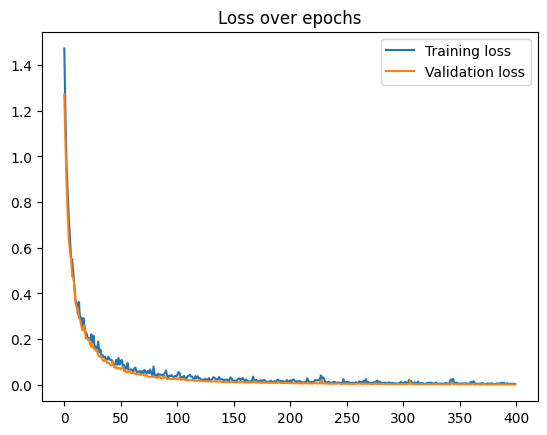

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Test Model with Seperated Test Data

In [20]:
def predict(model, image_path):
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil) #Already transformed into a tensor here
    
    model.eval()
    with torch.no_grad():
        predictions_log = model(image_tensor)
        predictions_prob = torch.exp(predictions_log)
        max_probability_predicted, max_probability_index = torch.max(predictions_prob, dim=1)
    return max_probability_index.item()

In [23]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = "test_data"
predicted, ground_truth = [], []
for style in os.listdir(TEST_FOLDER_DIR):
    correct_result = CLASSIFICATION_MAPPING[style]
    style_path = os.path.join(TEST_FOLDER_DIR, style)
    for pic in os.listdir(style_path):
        predicted_result = predict(model, os.path.join(style_path, pic))
        predicted.append(predicted_result)
        ground_truth.append(correct_result)

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
predicted = torch.tensor(predicted)
ground_truth = torch.tensor(ground_truth)

accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
precision = torchmetrics.Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
recall = torchmetrics.Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
f1score = torchmetrics.F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

In [ ]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

# Logging with MlFlow

In [ ]:
with mlflow.start_run():
    mlflow.log_params()
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("validation_loss", validation_loss)
    
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1", f1_score)

    mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")